#### Assignmet 1 - Computer Vision, Digit Classification

#### Imports

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [2]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

#### Import MNIST dataset, creating training and test sets

In [3]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

#### Exploratory Data Analysis

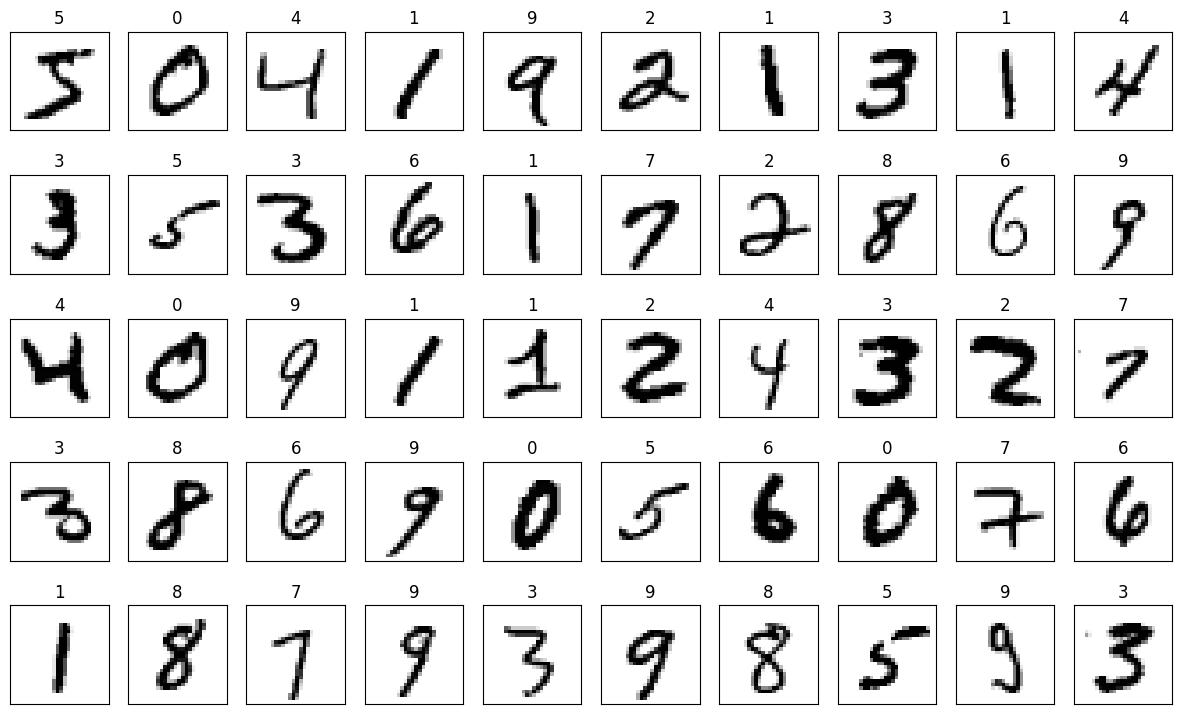

In [4]:
# First 50 images
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

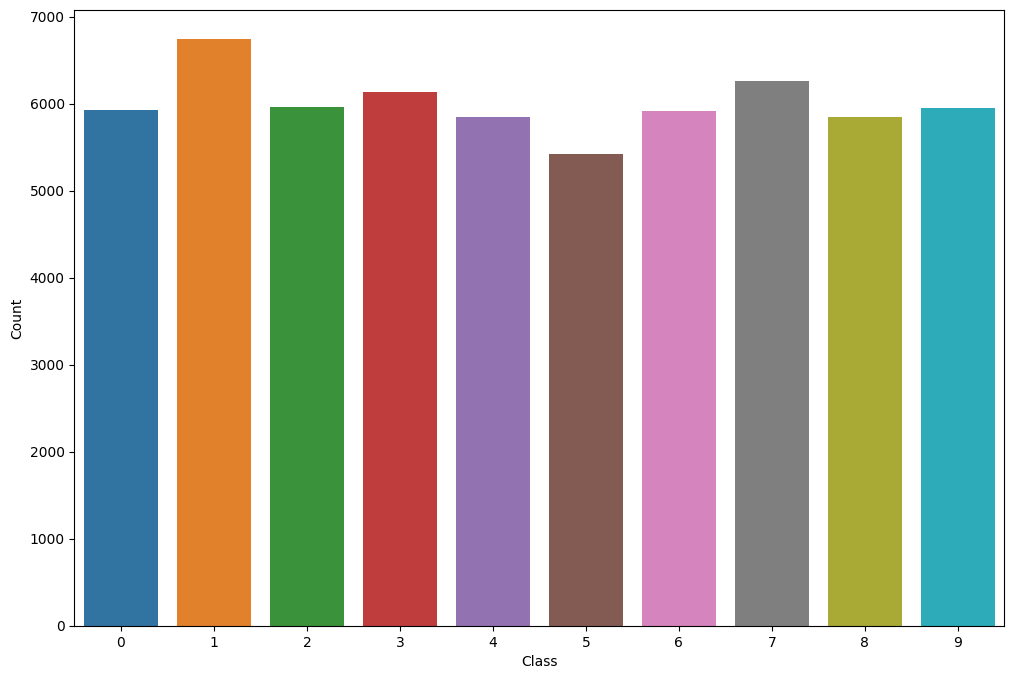

In [5]:
# Frequency chart of classificatinos
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [6]:
# Example of sample input
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2027]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  77 254 220   0   0   0   0   0   0   0   4  60  48 118  25   0   0   0   0   0   0   0   0]
 [  0   0   0   0  37 218 253 250 234 234 234 234 234 234 234 234 244 242 253 18

#### Data pre-processing

In [7]:
# Apply one hot encoding to the labels, creating binary variables for 0-9 indicating classification

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:4,]))

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)
First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
# Reshape the 28x28 inputs to 1x784

# Reshape the sets:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


In [9]:
# Normalize the inputs by dividing values by 255 (max greyscale value)

x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

#### Experiment Set 1

#### Experiment 1 - MLP with one hidden layer (1)

In [10]:
# Experiment 1

# Step 1 - Create model architecture using the Sequential class
model_one = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_one.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_one = history = model_one.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_one = tf.keras.models.load_model("model_one.h5")

# Step 4 - Predict the test set
preds_one = model_one.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 1s 539us/step - loss: 1.9681 - accuracy: 0.2205 - val_loss: 1.8543 - val_accuracy: 0.2338
Epoch 2/200
 387/1500 [======>.......................] - ETA: 0s - loss: 1.8530 - accuracy: 0.2343

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 1s 476us/step - loss: 1.8244 - accuracy: 0.2454 - val_loss: 1.7817 - val_accuracy: 0.2542
Epoch 3/200
1500/1500 [==============================] - 1s 471us/step - loss: 1.7757 - accuracy: 0.2770 - val_loss: 1.7467 - val_accuracy: 0.2943
Epoch 4/200
1500/1500 [==============================] - 1s 483us/step - loss: 1.7437 - accuracy: 0.3033 - val_loss: 1.7159 - val_accuracy: 0.3140
Epoch 5/200
1500/1500 [==============================] - 1s 527us/step - loss: 1.7105 - accuracy: 0.3310 - val_loss: 1.6806 - val_accuracy: 0.3487
Epoch 6/200
1500/1500 [==============================] - 1s 481us/step - loss: 1.6706 - accuracy: 0.3469 - val_loss: 1.6495 - val_accuracy: 0.3535
Epoch 7/200
1500/1500 [==============================] - 1s 482us/step - loss: 1.6423 - accuracy: 0.3544 - val_loss: 1.6267 - val_accuracy: 0.3543
Epoch 8/200
1500/1500 [==============================] - 1s 493us/step - loss: 1.6262 - accuracy: 0.3577 - val_loss: 1.6106 - val_

#### Experiment 2 - MLP with one hidden layer (2)

In [11]:
# Experiment 2

# Step 1 - Create model architecture using the Sequential class
model_two = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_two.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_two = history = model_two.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_two = tf.keras.models.load_model("model_two.h5")

# Step 4 - Predict the test set
preds_two = model_two.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 1s 516us/step - loss: 1.7049 - accuracy: 0.3268 - val_loss: 1.4877 - val_accuracy: 0.4069
Epoch 2/200
1500/1500 [==============================] - 1s 463us/step - loss: 1.3758 - accuracy: 0.4911 - val_loss: 1.2561 - val_accuracy: 0.5689
Epoch 3/200
1500/1500 [==============================] - 1s 472us/step - loss: 1.2261 - accuracy: 0.5727 - val_loss: 1.1666 - val_accuracy: 0.6028
Epoch 4/200
1500/1500 [==============================] - 1s 463us/step - loss: 1.1691 - accuracy: 0.5961 - val_loss: 1.1297 - val_accuracy: 0.6183
Epoch 5/200
1500/1500 [==============================] - 1s 463us/step - loss: 1.1366 - accuracy: 0.6143 - val_loss: 1.1002 - val_accuracy: 0.6248
Epoch 6/200
1500/1500 [==============================] - 1s 465us/step - loss: 1.1156 - accuracy: 0.6220 - val_loss: 1.0880 - val_accuracy: 0.6308
Epoch 7/200
1500/1500 [==============================] - 1s 465us/step - loss: 1.1023 - accuracy: 0.6261 - val_loss: 1

#### Experiment 3 - MLP with one hidden layer (10)

In [12]:
# Experiment 3

# Step 1 - Create model architecture using the Sequential class
model_three = Sequential([
    Dense(input_shape=[784], units=10, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_three.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_three = history = model_three.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_three = tf.keras.models.load_model("model_three.h5")

# Step 4 - Predict the test set
preds_three = model_three.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 1s 534us/step - loss: 0.5685 - accuracy: 0.8546 - val_loss: 0.3609 - val_accuracy: 0.9133
Epoch 2/200
1500/1500 [==============================] - 1s 519us/step - loss: 0.3694 - accuracy: 0.9077 - val_loss: 0.3423 - val_accuracy: 0.9166
Epoch 3/200
1500/1500 [==============================] - 1s 495us/step - loss: 0.3498 - accuracy: 0.9131 - val_loss: 0.3235 - val_accuracy: 0.9218
Epoch 4/200
1500/1500 [==============================] - 1s 496us/step - loss: 0.3367 - accuracy: 0.9166 - val_loss: 0.3231 - val_accuracy: 0.9220
Epoch 5/200
1500/1500 [==============================] - 1s 481us/step - loss: 0.3259 - accuracy: 0.9189 - val_loss: 0.3139 - val_accuracy: 0.9225
Epoch 6/200
1500/1500 [==============================] - 1s 475us/step - loss: 0.3167 - accuracy: 0.9210 - val_loss: 0.3021 - val_accuracy: 0.9277
Epoch 7/200
1500/1500 [==============================] - 1s 478us/step - loss: 0.3084 - accuracy: 0.9227 - val_loss: 0

#### Experiment 4 - MLP with one hidden-layer (128)

In [13]:
# Experiment 4

# Step 1 - Create model architecture using the Sequential class
model_four = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_four.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_four = model_four.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_four = tf.keras.models.load_model("model_four.h5")

# Step 4 - Predict the test set
preds_four = model_four.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3965 - accuracy: 0.9148 - val_loss: 0.2588 - val_accuracy: 0.9481
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2390 - accuracy: 0.9515 - val_loss: 0.2031 - val_accuracy: 0.9618
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2000 - accuracy: 0.9598 - val_loss: 0.1857 - val_accuracy: 0.9626
Epoch 4/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1821 - accuracy: 0.9634 - val_loss: 0.1809 - val_accuracy: 0.9616
Epoch 5/200
313/313 [==============================] - 0s 394us/step


#### Experiment Set 1 Results

#### Experiment Set 2

#### Experiment 5 - MLP with one hidden layer (128), adam optimizer

In [14]:
# Experiment 5

# Step 1 - Create model architecture using the Sequential class
model_five = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_five.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_five = model_five.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_five = tf.keras.models.load_model("model_five.h5")

# Step 4 - Predict the test set
preds_five = model_five.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 999us/step - loss: 0.4135 - accuracy: 0.9148 - val_loss: 0.2719 - val_accuracy: 0.9470
Epoch 2/200
1500/1500 [==============================] - 1s 992us/step - loss: 0.2489 - accuracy: 0.9531 - val_loss: 0.2251 - val_accuracy: 0.9599
Epoch 3/200
1500/1500 [==============================] - 1s 866us/step - loss: 0.2163 - accuracy: 0.9609 - val_loss: 0.1990 - val_accuracy: 0.9679
Epoch 4/200
1500/1500 [==============================] - 1s 898us/step - loss: 0.1980 - accuracy: 0.9648 - val_loss: 0.1991 - val_accuracy: 0.9646
Epoch 5/200
313/313 [==============================] - 0s 399us/step


#### Experiment 6 - MLP with two hidden layers (128, 64), rmsprop optimizer

In [15]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_six = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_six.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_six = model_six.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_six = tf.keras.models.load_model("model_six.h5")

# Step 4 - Predict the test set
preds_six = model_six.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4403 - accuracy: 0.9178 - val_loss: 0.2893 - val_accuracy: 0.9536
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2584 - accuracy: 0.9568 - val_loss: 0.2171 - val_accuracy: 0.9659
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2188 - accuracy: 0.9627 - val_loss: 0.2107 - val_accuracy: 0.9621
Epoch 4/200
313/313 [==============================] - 0s 399us/step


#### Experiment 7 - MLP with two hidden layers (128, 64), adam optimizer

In [16]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_seven = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_seven.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_seven = model_seven.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_seven = tf.keras.models.load_model("model_seven.h5")

# Step 4 - Predict the test set
preds_seven = model_seven.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4609 - accuracy: 0.9158 - val_loss: 0.3181 - val_accuracy: 0.9502
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2832 - accuracy: 0.9563 - val_loss: 0.2526 - val_accuracy: 0.9614
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2425 - accuracy: 0.9627 - val_loss: 0.2386 - val_accuracy: 0.9610
Epoch 4/200
1500/1500 [==============================] - 1s 976us/step - loss: 0.2210 - accuracy: 0.9667 - val_loss: 0.2197 - val_accuracy: 0.9665
Epoch 5/200
1500/1500 [==============================] - 1s 968us/step - loss: 0.2052 - accuracy: 0.9699 - val_loss: 0.2062 - val_accuracy: 0.9681
Epoch 6/200
1500/1500 [==============================] - 1s 979us/step - loss: 0.1965 - accuracy: 0.9709 - val_loss: 0.2085 - val_accuracy: 0.9659
Epoch 7/200
313/313 [==============================] - 0s 409us/step


#### Experiment 8 - MLP with three hidden layers (128, 64, 32), adam optimizer

In [17]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_eight = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[64],units=32,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_eight.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_eight = model_eight.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_eight = tf.keras.models.load_model("model_eight.h5")

# Step 4 - Predict the test set
preds_eight = model_eight.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5069 - accuracy: 0.9104 - val_loss: 0.3351 - val_accuracy: 0.9529
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3114 - accuracy: 0.9551 - val_loss: 0.2822 - val_accuracy: 0.9638
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2631 - accuracy: 0.9641 - val_loss: 0.2589 - val_accuracy: 0.9635
Epoch 4/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2437 - accuracy: 0.9660 - val_loss: 0.2380 - val_accuracy: 0.9673
Epoch 5/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2249 - accuracy: 0.9703 - val_loss: 0.2397 - val_accuracy: 0.9663
Epoch 6/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2143 - accuracy: 0.9711 - val_loss: 0.2185 - val_accuracy: 0.9709
Epoch 7/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2077 - accuracy: 0.9714 - val_loss: 0.2121 - val_ac

#### Experiment Set 2 Results

#### Experiment Set 3 - Feature Engineering

#### Experiment 9 - Feature Engineering via Pincipal Component Analysis

#### Experiment 10 - Feature Engineering via Random Forest

#### Experiment Set 3 Results